# Описание этапа

На данном этапе вам необходимо:

* Сформировать обучающую выборку

* Спроектировать схему валидации с учетом специфики задачи

* Обосновать выбор способа валидации

# Проектирование схемы валидации

Прежде, чем выбирать метрики качества для модели рекомендательных систем, необходимо грамотно выбрать схему валидации, учитывая специфику задачии и данных.

#### Существующие подходы для разбиения данных:

1. Случайное разбиение:
* Leave one out
 * Для test оставляем одно случайное взаимодействие
* Leave P out
 * Для test оставляем P случайных взаимодействий
2. Хронологическое разбиение:
* Оставляем в test только последние взаимодействия по пользователям или объектам
 * Last one out
 * Last P out
3. Разбиение по времени:
* Оставляем в test только конкретный временной промежуток, например последний день или последняя неделя
---
При генерации надо учитывать так же cold start и warm start сценарии

# Анализ данных для выбора метода валидации

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/WBTECH')

In [ ]:
df = pd.read_parquet('clickstream.parquet')

In [ ]:
df.head()

In [ ]:
# Всего пользователей
df['wbuser_id'].nunique()

In [ ]:
# Пользователей в 10 день
df[df['day'] == 10]['wbuser_id'].nunique()

In [ ]:
# Товаров в 10 день
df[df['day'] == 10]['nm_id'].nunique()

In [ ]:
# Пользователей в 11 день
df[df['day'] == 11]['wbuser_id'].nunique()

In [ ]:
# Пользователей в 11 день
df[df['day'] == 11]['nm_id'].nunique()

In [ ]:
users_day10 = set(df[df['day'] == 10]['wbuser_id'])

users_day11 = set(df[df['day'] == 11]['wbuser_id'])

unique_day11_users = users_day11 - users_day10

count_unique_day11 = len(unique_day11_users)

print(f"Количество пользователей, которые смотрели товары в 11 день и не смотрели в 10 день: {count_unique_day11}")

In [ ]:
# Посчитаем количество взаимодействий для каждого пользователя
user_counts = df['wbuser_id'].value_counts()

In [ ]:
# Посчитаем у скольких пользователей меньше 3 взаимодействий
min_val = 2
filtered_values = user_counts[user_counts <= min_val]

In [ ]:
# Количество пользователей во всем датасете у кого меньше 3 взаимодействий
len(filtered_values)

In [ ]:
# Составим датасет только для взаимодействий в 11 день
day_11 = df[df['day'] == 11]

In [ ]:
# Посчитаем количество взаимодействий пользователей в 11 день
user_counts_11 = day_11['wbuser_id'].value_counts()

In [ ]:
# Количество пользователей у кого 11 числа меньше 3 взаимодействий
min_val = 2
filtered_values1 = user_counts_11[user_counts_11 <= min_val]
print(len(filtered_values1))

In [ ]:
# Количество пользователей с 3 и с более чем 3 взаимодействиями в 11 день
min_val = 3
filtered_values2 = user_counts_11[user_counts_11 == min_val]
filtered_values3 = user_counts_11[user_counts_11 > min_val]

In [ ]:
len(filtered_values2), len(filtered_values3)

In [ ]:
# Посмотрим, сколько пользователей из общего датасета с менее, чем 3 взаимодействиями относятся к 11 дню и не относятся к 10

# Фильтруем `filtered_values1` по наличию в `users_day11`
common_users_series = filtered_values1[filtered_values1.index.isin(unique_day11_users)]

# Количество общих пользователей
num_common_users = common_users_series.count()

print(f"Количество пользователей у которых меньше: {num_common_users}")

In [ ]:
# Считаем количество взаимодействий каждого пользователя
user_interactions = df.groupby('wbuser_id').size()

# Выбираем пользователей, у которых меньше 3 взаимодействий
users_less_than_3 = user_interactions[user_interactions < 3].index

# Фильтруем исходный DataFrame только с пользователями, у которых <3 взаимодействия
filtered_df = df[df['wbuser_id'].isin(users_less_than_3)]

# 1. Пользователи, взаимодействия которых только в 11-й день
only_day_11_users = filtered_df.groupby('wbuser_id')['day'].unique()
only_day_11_users = [user for user, days in only_day_11_users.items() if set(days) == {11}]

# Количество таких пользователей
count_only_day_11_users = len(only_day_11_users)

# 2. Пользователи, которые взаимодействовали и в 10-й, и в 11-й день
both_days_users = filtered_df.groupby('wbuser_id')['day'].unique()
both_days_users = [user for user, days in both_days_users.items() if set(days) == {10, 11}]

# Количество таких пользователей
count_both_days_users = len(both_days_users)

# Результаты
print("Количество пользователей, <3 взаимодействий, только в 11 день:", count_only_day_11_users)
print("Количество пользователей, <3 взаимодействий, в 10 и 11 дни:", count_both_days_users)

In [ ]:
only_day_10_users = filtered_df.groupby('wbuser_id')['day'].unique()
only_day_10_users = [user for user, days in only_day_10_users.items() if set(days) == {10}]

# Количество таких пользователей
count_only_day_10_users = len(only_day_10_users)

print("Количество пользователей, <3 взаимодействий, только в 10 день:", count_only_day_10_users)

#### Теперь, когда у нас есть больше информации о специфике датасета, можно выделить некоторые ключевые особенности:
* Данные собраны всего за два дня
* 1.5 миллиона пользователей имеют меньше трех взаимодействий
* За 11 день появилось 1,5 миллиона пользователей, которые не взаимодействовали в предыдущий день, и всего 800 тысяч пользователей взаимодействовали оба дня
* Есть 660 тысяч пользователей, которые взаимодействовали в 11 день менее трех раз и все эти пользователи - новые пользователи относительно 10 дня. 50 тысяч пользователей взаимодействовали менее 3 раз по 1 взаимодействию каждый день

#### Выводы:
* Разделять по времени, например, оставивлять последние 6 часов на тест - не совсем корректный подход. Навряд ли при такой валидации можно будет сказать, что полученная модель хорошо или плохо предсказывает поведение пользователей в течение всего дня. К тому же при таком разбиении в подавляющем количестве пользователи будут холодными, что дополнительно помешает понять как модель справляется с рекомендациями для пользователей, которые уже совершали действия
* Так как для нас важна хронология событий, оставлять для теста случайные взаимодействия тоже плохой подход. Нужно оставлять для теста последние события
* Если забрать последние события у всех пользователей, то модели будет не на чем учиться, так как, например, забрав у всех пользователей, у которых было 3 взаимодействия, 2 последних, модель не сможет научиться определять для такой группы пользователей следующие взаимодействия

# Выбранная схема создания обучающей, валидационной и тестовых выборок

Схематически выбранный метод представлен на рисунке:

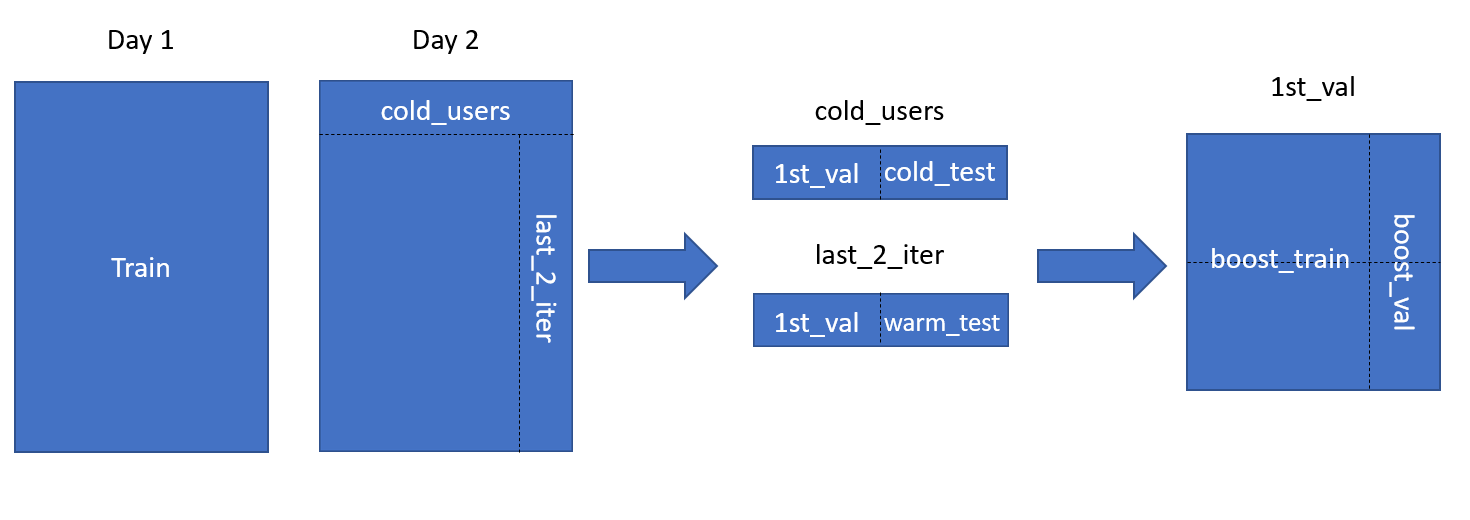

#### Создание выборок по шагам:

1. 10 день оставляем полностью под трейн
2. Из 11 дня выбираем все взаимодействия для пользователей 1-2 взаимодействиями. Они будут холодными пользователями (cold_users)
3. У оставшихся пользователей выбираем 2 последних взаимодействия. Это будут теплые пользователи (last_2_iter)
4. Делим cold_users. Одна половина станет общим тестом итоговой модели для проверки работоспособности на холодных пользователях (cold_test). Вторая пойдет в валидационный датасет моделей первого этапа (1st_val_cold)
5. Аналогично поступаем для last_2_iter. Одна половина станет тестом итоговом модели для проверки на теплых пользователях (warm_test). Вторая пойдет в валидационный датасет (1st_val_warm)
6. 1st_val так же надо разбить на boost_train и boost_val. Деление будет происходить так: отдельно из 1st_val_cold и 1st_val_warm берем последнее взаимодействие для рандомных пользователей так, чтобы конечное разделение получилось примерно 80%/20%. (1st_val_warm_train/1st_val_warm_val и 1st_val_cold_train/1st_val_cold_val)
7. Объединяем 1st_val_warm_train и 1st_val_cold_train в boost_train, а 1st_val_warm_val и 1st_val_cold_val в boost_val

Преимущества используемого подхода:
* Оставляем достаточно данных на обучение модели
* Полученные выборки получаются достаточно сбалансированными
* Полученные выборки достаточно интерпретируемы, так же учитываем взаимодействия в течение всего дня, а не нескольких последних часов
* Сохраняется хронологический порядок действий пользователей
* Модель обучается и на теплых и на холодных пользователях
* Мы можем отдельно проверить работоспособность модели на холодных и на теплых пользователях

#### Теперь создадим эти выборки

In [ ]:
# Список всех пользователей двух категорий
all_users = set(only_day_11_users) | set(both_days_users)

In [ ]:
len(all_users)

In [ ]:
cold_users = df[df['wbuser_id'].isin(all_users)]

In [ ]:
cold_users.shape

In [ ]:
# Удаляем эти взаимодействия из исходного датасета
df = df[~df['wbuser_id'].isin(all_users)]

In [ ]:
# 2. Создаем список пользователей, которые взаимодействовали в 11 день
users_day_11 = df[df['day'] == 11]['wbuser_id'].unique()

In [ ]:
# Проверяем количество взаимодействий этих пользователей
interactions_count = df[df['wbuser_id'].isin(users_day_11)]['wbuser_id'].value_counts()

In [ ]:
interactions_count

In [ ]:
df_sorted = df[df['wbuser_id'].isin(users_day_11)].sort_values(['wbuser_id', 'dt'])

In [ ]:
df_sorted

In [ ]:
# Шаг 3: Выбор последних двух взаимодействий для каждого пользователя
last_2_iter = df_sorted.groupby('wbuser_id').tail(2).copy()

In [ ]:
last_2_iter

In [ ]:
# Удаляем эти взаимодействия из исходного df
df = df[~df.index.isin(last_2_iter.index)]

In [ ]:
# 1. Рандомно делим пользователей из `cold_users` на две группы
cold_users_ids = cold_users['wbuser_id'].unique()  # Уникальные пользователи
np.random.shuffle(cold_users_ids)  # Перемешиваем пользователей случайным образом

split_index_cold = len(cold_users_ids) // 2  # Индекс для деления 50:50
first_val_cold = cold_users[cold_users['wbuser_id'].isin(cold_users_ids[:split_index_cold])]
cold_test = cold_users[cold_users['wbuser_id'].isin(cold_users_ids[split_index_cold:])]

In [ ]:
# 2. Рандомно делим пользователей из `last_2_iter` на две группы
last_users_ids = last_2_iter['wbuser_id'].unique()  # Уникальные пользователи
np.random.shuffle(last_users_ids)  # Перемешиваем пользователей

split_index_last = len(last_users_ids) // 2  # Индекс для деления 50:50
first_val_warm = last_2_iter[last_2_iter['wbuser_id'].isin(last_users_ids[:split_index_last])]
warm_test = last_2_iter[last_2_iter['wbuser_id'].isin(last_users_ids[split_index_last:])]

In [ ]:
first_val_cold.shape, first_val_warm.shape

In [ ]:
cold_test.shape, warm_test.shape

In [ ]:
first_val_cold['wbuser_id'].nunique(), first_val_warm['wbuser_id'].nunique()

In [ ]:
first_val = pd.concat([first_val_cold, first_val_warm], axis=0)

In [ ]:
# Получаем уникальные user_id
users_warm = first_val_warm['wbuser_id'].unique()

# Определяем количество пользователей для выборки (40%)
num_users_warm = int(len(users_warm) * 0.4)

# Устанавливаем фиксированный seed для воспроизводимости (опционально)
np.random.seed(42)

# Случайно выбираем 40% пользователей
selected_users_warm = np.random.choice(users_warm, size=num_users_warm, replace=False)

In [ ]:
# Получаем уникальные user_id
users_cold = first_val_cold['wbuser_id'].unique()

# Определяем количество пользователей для выборки (27%)
num_users_cold = int(len(users_cold) * 0.27)

# Случайно выбираем 27% пользователей
selected_users_cold = np.random.choice(users_cold, size=num_users_cold, replace=False)


In [ ]:
# Фильтруем данные для выбранных пользователей
filtered_warm = first_val_warm[first_val_warm['wbuser_id'].isin(selected_users_warm)]

# Сортируем по 'wbuser_id' и 'dt' для выбора последних взаимодействий
filtered_warm_sorted = filtered_warm.sort_values(by=['wbuser_id', 'dt'])

# Группируем по 'wbuser_id' и выбираем последнее взаимодействие
last_interactions_warm = filtered_warm_sorted.groupby('wbuser_id').tail(1)

In [ ]:
# Фильтруем данные для выбранных пользователей
filtered_cold = first_val_cold[first_val_cold['wbuser_id'].isin(selected_users_cold)]

# Сортируем по 'wbuser_id' и 'dt' для выбора последних взаимодействий
filtered_cold_sorted = filtered_cold.sort_values(by=['wbuser_id', 'dt'])

# Группируем по 'wbuser_id' и выбираем последнее взаимодействие
last_interactions_cold = filtered_cold_sorted.groupby('wbuser_id').tail(1)


In [ ]:
boost_val = pd.concat([last_interactions_warm, last_interactions_cold], axis=0)

In [ ]:
# Получим индексы последних взаимодействий
indices_to_remove_warm = last_interactions_warm.index
indices_to_remove_cold = last_interactions_cold.index

# Удалим строки из оригинальных DataFrame
boost_train_warm = first_val_warm.drop(indices_to_remove_warm)
boost_train_cold = first_val_cold.drop(indices_to_remove_cold)

In [ ]:
boost_train = pd.concat([boost_train_warm, boost_train_cold], axis=0)

In [ ]:
boost_train.to_parquet('boost_train.parquet')
boost_val.to_parquet('boost_val.parquet')
first_val.to_parquet('first_val.parquet')
cold_test.to_parquet('cold_test.parquet')
warm_test.to_parquet('warm_test.parquet')
df.to_parquet('first_train.parquet')

In [ ]:
first_val = pd.read_parquet('first_val.parquet')

In [ ]:
boost_train = pd.read_parquet('boost_train.parquet')

In [ ]:
first_val['nm_id'].nunique()

In [ ]:
boost_train['nm_id'].nunique()

In [2]:
interactions_df = pd.read_parquet('first_train.parquet')

In [3]:
interactions_df = interactions_df.drop(['dt', 'day', 'hour'], axis=1)

In [4]:
interactions_df = interactions_df.groupby(["wbuser_id", "nm_id"]).agg({"nm_id": "count",}).rename(columns={"nm_id": "user_item_count",}).reset_index()

interactions_df

,wbuser_id,nm_id,user_item_count
0,1,17528,4
1,1,31178,1
2,1,32385,1
3,1,43287,1
4,1,57951,1
...,...,...,...
42826426,5168286,416587,1
42826427,5168287,416587,1
42826428,5168288,132779,1
42826429,5168289,132779,1


In [5]:
total_users_interactions_count = interactions_df[["wbuser_id", "user_item_count"]].groupby("wbuser_id").sum().rename(columns={"user_item_count": "user_inter_count",})

total_users_interactions_count

,user_inter_count
wbuser_id,
1,74
3,31
5,65
8,2
9,41
...,...
5168286,1
5168287,1
5168288,1


In [6]:
interactions_df = interactions_df.join(total_users_interactions_count,on="wbuser_id",how="left")

interactions_df["user_item_rating"] = interactions_df["user_item_count"] / interactions_df["user_inter_count"]

interactions_df

,wbuser_id,nm_id,user_item_count,user_inter_count,user_item_rating
0,1,17528,4,74,0.054054
1,1,31178,1,74,0.013514
2,1,32385,1,74,0.013514
3,1,43287,1,74,0.013514
4,1,57951,1,74,0.013514
...,...,...,...,...,...
42826426,5168286,416587,1,1,1.000000
42826427,5168287,416587,1,1,1.000000
42826428,5168288,132779,1,1,1.000000
42826429,5168289,132779,1,1,1.000000


In [7]:
item_rating_df = interactions_df[["nm_id", "user_item_count"]].groupby("nm_id").sum().rename(columns={"user_item_count": "item_count",})

item_rating_df["item_rating"] = item_rating_df["item_count"] / item_rating_df.shape[0]

item_rating_df = item_rating_df.reset_index()

In [8]:
item_rating_df = item_rating_df.sort_values("item_rating", ascending=False)
item_rating_df

,nm_id,item_count,item_rating
124172,181754,30885,0.107534
33905,49604,29264,0.101890
59582,87095,28740,0.100065
279614,408645,25385,0.088384
50548,73874,24438,0.085087
...,...,...,...
47847,69902,1,0.000003
64406,94216,1,0.000003
120018,175632,1,0.000003
47923,70014,1,0.000003


In [43]:
item_rating_df[item_rating_df['nm_id'] == 388119]

,nm_id,item_count,item_rating
265519,388119,93,0.000324


In [21]:
items = pd.read_parquet('image_exists.parquet')

In [23]:
items.head()

,nm_id,title_is_empty,description_is_empty,description_len,title_len,aaawesomeapparelbykseniaavakyan,aandre,abbiroom,abitonero,adenashop,...,округлый_горло,v-образный_горло,воротник-стойка_горло,лодочка_горло,отложной воротник,фигурный_горло,квадратный_горло,на бретельках_горло,каре_горло,image_exists
6,125164,0,0,191,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
9,125318,0,0,48,5,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,True
10,278520,0,0,215,6,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True
11,103322,0,0,160,5,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,True
12,147223,0,0,65,3,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,True


In [10]:
embeddings = pd.read_parquet('emb_final.parquet')

In [45]:
embeddings

,embedding,image_exists,emb_256,emb_512
6,"[0.0, 0.010920315980911255, 0.0, 0.0, 2.132319...",True,"[0.0, 0.0, 1.019516944885254, 1.89236760139465...","[0.0, 6.863319396972656, 0.0, 7.61949825286865..."
9,"[0.0, 1.0099595785140991, 0.0, 0.0, 1.09929490...",True,"[0.0, 0.0, 0.0, 6.587592124938965, 0.0, 0.0670...","[0.15575285255908966, 7.59351921081543, 0.0, 7..."
10,"[0.1468191146850586, 1.249854564666748, 0.0, 0...",True,"[0.0, 0.0, 3.1754467487335205, 0.9127578139305...","[0.0, 8.054011344909668, 0.0, 1.66006565093994..."
11,"[0.05202281475067139, 0.607856273651123, 0.0, ...",True,"[0.0, 0.0, 0.0, 4.705138206481934, 0.0, 1.9730...","[1.257143497467041, 5.365643501281738, 0.0, 4...."
12,"[0.0, 0.0, 0.0, 0.0, 3.5197558403015137, 0.0, ...",True,"[0.0, 0.0, 3.0406785011291504, 1.2049230337142...","[1.7657908201217651, 9.050690650939941, 0.0, 3..."
...,...,...,...,...
419760,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,"[0.0, 0.0, 0.0, 5.270199775695801, 0.0, 1.0166...","[0.04418718069791794, 5.164177894592285, 0.0, ..."
419761,"[0.0, 2.484447479248047, 0.0, 0.0, 0.0, 0.0, 0...",True,"[0.0, 0.0, 0.0, 2.506082534790039, 0.0, 0.0, 0...","[1.8907876014709473, 9.677355766296387, 0.0, 4..."
419763,"[0.0, 0.0, 0.20407900214195251, 0.0, 0.7721452...",True,"[0.0, 0.34623318910598755, 1.3420493602752686,...","[1.6014869213104248, 7.137309551239014, 0.0, 5..."
419764,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,"[0.0, 0.31721681356430054, 0.9498865604400635,...","[0.0, 6.899765968322754, 0.0, 5.84300422668457..."


In [25]:
result = items.merge(item_rating_df, on='nm_id', how='left')
result

,nm_id,title_is_empty,description_is_empty,description_len,title_len,aaawesomeapparelbykseniaavakyan,aandre,abbiroom,abitonero,adenashop,...,воротник-стойка_горло,лодочка_горло,отложной воротник,фигурный_горло,квадратный_горло,на бретельках_горло,каре_горло,image_exists,item_count,item_rating
0,125164,0,0,191,7,0,0,0,0,0,...,0,0,0,0,0,0,0,True,138.0,0.000480
1,125318,0,0,48,5,0,0,0,0,0,...,0,0,0,0,0,0,0,True,8.0,0.000028
2,278520,0,0,215,6,0,0,0,0,0,...,0,0,0,0,0,0,0,True,739.0,0.002573
3,103322,0,0,160,5,0,0,0,0,0,...,0,0,0,0,0,0,0,True,2.0,0.000007
4,147223,0,0,65,3,0,0,0,0,0,...,0,0,0,0,0,0,0,True,113.0,0.000393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287368,157528,0,0,137,3,0,0,0,0,0,...,0,0,0,0,0,0,0,True,18.0,0.000063
287369,26115,0,0,85,4,0,0,0,0,0,...,0,0,0,0,0,0,0,True,11.0,0.000038
287370,59167,0,0,244,3,0,0,0,0,0,...,1,0,0,0,0,0,0,True,437.0,0.001522
287371,36971,0,0,170,3,0,0,0,0,0,...,0,0,0,0,0,0,0,True,537.0,0.001870


In [26]:
result.index = items.index

In [28]:
items = result

In [30]:
items = items.drop(['item_count'], axis=1)

In [31]:
items

,nm_id,title_is_empty,description_is_empty,description_len,title_len,aaawesomeapparelbykseniaavakyan,aandre,abbiroom,abitonero,adenashop,...,v-образный_горло,воротник-стойка_горло,лодочка_горло,отложной воротник,фигурный_горло,квадратный_горло,на бретельках_горло,каре_горло,image_exists,item_rating
6,125164,0,0,191,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,0.000480
9,125318,0,0,48,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,0.000028
10,278520,0,0,215,6,0,0,0,0,0,...,1,0,0,0,0,0,0,0,True,0.002573
11,103322,0,0,160,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,0.000007
12,147223,0,0,65,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,0.000393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419760,157528,0,0,137,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,0.000063
419761,26115,0,0,85,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,0.000038
419763,59167,0,0,244,3,0,0,0,0,0,...,0,1,0,0,0,0,0,0,True,0.001522
419764,36971,0,0,170,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,0.001870


In [32]:
items *= 1
items = items.fillna(0)

In [34]:
items.index = items.index.astype(int)
embeddings.index = embeddings.index.astype(int)

In [35]:
    items.index.name = None
    embeddings.index.name = None

In [36]:
items = pd.merge(
    items,
    embeddings['emb_256'],
    left_index=True,
    right_index=True,
    how='left'
)

In [38]:
items[items["nm_id"] == 125164]

,nm_id,title_is_empty,description_is_empty,description_len,title_len,aaawesomeapparelbykseniaavakyan,aandre,abbiroom,abitonero,adenashop,...,воротник-стойка_горло,лодочка_горло,отложной воротник,фигурный_горло,квадратный_горло,на бретельках_горло,каре_горло,image_exists,item_rating,emb_256
6,125164,0,0,191,7,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.00048,"[0.0, 0.0, 1.019516944885254, 1.89236760139465..."


In [40]:
   # Проверим, что колонка 'emb_256' содержит списки или массивы
   if isinstance(items['emb_256'].iloc[0], (list, np.ndarray)):
       # Преобразуем колонку 'emb_256' в 256 отдельных колонок
       embeddings_expanded = pd.DataFrame(items['emb_256'].tolist(), index=items.index)

       # Переименуем колонки для удобства, например: 'emb_0', 'emb_1', ..., 'emb_255'
       embeddings_expanded = embeddings_expanded.rename(
           columns=lambda x: f'emb_{x}'
       )

       # Объединим с основным датафреймом и удалим колонку 'emb_256'
       items = pd.concat([items.drop('emb_256', axis=1), embeddings_expanded], axis=1)
   else:
       raise ValueError("Колонка 'emb_256' должна содержать списки или numpy массивы.")

In [41]:
items

,nm_id,title_is_empty,description_is_empty,description_len,title_len,aaawesomeapparelbykseniaavakyan,aandre,abbiroom,abitonero,adenashop,...,emb_246,emb_247,emb_248,emb_249,emb_250,emb_251,emb_252,emb_253,emb_254,emb_255
6,125164,0,0,191,7,0,0,0,0,0,...,0.000000,0.000000,0.810445,0.0,2.104319,1.40109,0.000000,0.000000,6.201933,1.151781
9,125318,0,0,48,5,0,0,0,0,0,...,8.418839,2.163776,3.530785,0.0,1.446571,0.00000,0.000000,1.588184,2.904060,0.000000
10,278520,0,0,215,6,0,0,0,0,0,...,0.000000,4.811216,2.303313,0.0,2.700516,0.00000,0.000000,4.584482,4.052521,0.000000
11,103322,0,0,160,5,0,0,0,0,0,...,0.000000,6.482931,0.000000,0.0,3.615185,0.00000,0.000000,5.441417,2.277659,1.979897
12,147223,0,0,65,3,0,0,0,0,0,...,0.000000,3.320075,0.000000,0.0,4.610911,0.00000,0.000000,6.826094,1.238520,0.109996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419760,157528,0,0,137,3,0,0,0,0,0,...,0.000000,3.580948,2.276637,0.0,3.117335,0.00000,0.000000,4.570114,4.667012,0.000000
419761,26115,0,0,85,4,0,0,0,0,0,...,0.000000,5.179999,0.000000,0.0,3.492666,0.00000,0.000000,4.461433,1.988555,0.000000
419763,59167,0,0,244,3,0,0,0,0,0,...,0.000000,4.274817,2.450690,0.0,4.424109,0.00000,0.000000,3.231980,5.134134,0.019848
419764,36971,0,0,170,3,0,0,0,0,0,...,0.000000,2.034901,0.000000,0.0,2.884373,0.00000,0.000000,3.464580,3.986975,0.491763


In [44]:
items[items['nm_id'] == 388119][['emb_0', 'emb_1', 'emb_2']]

,emb_0,emb_1,emb_2
419765,0.0,0.427697,2.021472


In [42]:
items.to_parquet('items_min.parquet')

# Уменьшение датасета

In [1]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/WBTECH')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_parquet('clickstream.parquet')

In [3]:
user_counts = df['wbuser_id'].value_counts()

In [4]:
print(len(user_counts[user_counts >= 10]))
print(len(user_counts[user_counts >= 11]))
print(len(user_counts[user_counts >= 12]))
print(len(user_counts[user_counts >= 14]))

1291300
1208994
1136059
1012484


In [5]:
item_counts = df['nm_id'].value_counts()

In [6]:
print(len(item_counts[item_counts >= 10]))

211680


In [7]:
items_to_keep = item_counts[item_counts >= 10].index

filtered_df = df[df['nm_id'].isin(items_to_keep)]

In [8]:
for i in range(4):
  # Установка фиксированного состояния для воспроизводимости
  random_seed = 42

  # Шаг 1: Получение уникальных значений nm_id
  unique_nm_ids = filtered_df['nm_id'].unique()
  total_unique = len(unique_nm_ids)
  print(f"Всего уникальных nm_id: {total_unique}")

  # Шаг 2: Расчёт количества nm_id для удаления (50%)
  num_to_remove = total_unique // 2  # Используем целочисленное деление

  # Шаг 3: Случайный выбор 50% nm_id
  # Используем функцию np.random.choice для случайного выбора без замены
  np.random.seed(random_seed)  # Устанавливаем семя для воспроизводимости
  nm_ids_to_remove = np.random.choice(unique_nm_ids, size=num_to_remove, replace=False)

  print(f"Количество nm_id, которые будут удалены: {len(nm_ids_to_remove)}")

  # (Альтернативный метод с использованием pandas)
  # nm_ids_to_remove = pd.Series(unique_nm_ids).sample(frac=0.5, random_state=random_seed).tolist()

  # Шаг 4: Фильтрация датафрейма для удаления строк с выбранными nm_id
  filtered_df_remaining = filtered_df[~filtered_df['nm_id'].isin(nm_ids_to_remove)].copy()

  print(f"Количество строк до удаления: {filtered_df.shape[0]}")
  print(f"Количество строк после удаления: {filtered_df_remaining.shape[0]}")
  filtered_df = filtered_df_remaining

Всего уникальных nm_id: 211680
Количество nm_id, которые будут удалены: 105840
Количество строк до удаления: 58290492
Количество строк после удаления: 28932345
Всего уникальных nm_id: 105840
Количество nm_id, которые будут удалены: 52920
Количество строк до удаления: 28932345
Количество строк после удаления: 14316641
Всего уникальных nm_id: 52920
Количество nm_id, которые будут удалены: 26460
Количество строк до удаления: 14316641
Количество строк после удаления: 7050930
Всего уникальных nm_id: 26460
Количество nm_id, которые будут удалены: 13230
Количество строк до удаления: 7050930
Количество строк после удаления: 3531679


In [9]:
user_counts = filtered_df['wbuser_id'].value_counts()

In [10]:
print(len(user_counts[user_counts >= 5]))
print(len(user_counts[user_counts >= 6]))
print(len(user_counts[user_counts >= 10]))
print(len(user_counts[user_counts >= 11]))
print(len(user_counts[user_counts >= 12]))
print(len(user_counts[user_counts >= 14]))

193736
141790
50870
40930
33298
22617


In [11]:
users_to_keep = user_counts[user_counts >= 5].index

filtered_df = filtered_df[filtered_df['wbuser_id'].isin(users_to_keep)]

In [12]:
item_counts = filtered_df['nm_id'].value_counts()
print(len(item_counts[item_counts <= 2]))

230


In [13]:
items_to_keep = item_counts[item_counts >= 3].index

filtered_df = filtered_df[filtered_df['nm_id'].isin(items_to_keep)]

In [15]:
user_counts = filtered_df['wbuser_id'].value_counts()
print(len(user_counts[user_counts <= 5]))

51999


In [22]:
users_to_keep = user_counts[user_counts >= 5].index

filtered_df = filtered_df[filtered_df['wbuser_id'].isin(users_to_keep)]

In [23]:
item_counts = filtered_df['nm_id'].value_counts()
print(len(item_counts[item_counts <= 2]))

0


In [18]:
items_to_keep = item_counts[item_counts >= 3].index

filtered_df = filtered_df[filtered_df['nm_id'].isin(items_to_keep)]

In [24]:
user_counts = filtered_df['wbuser_id'].value_counts()
print(len(user_counts[user_counts <= 5]))

51939


In [23]:
item_counts = filtered_df['nm_id'].value_counts()
print(len(item_counts[item_counts <= 2]))

0


In [27]:
filtered_df.to_parquet('cut_clickstream_2.paqruet')

In [34]:
filtered_df = pd.read_parquet('cut_clickstream_2.paqruet')

In [28]:
# 1. Пользователи, взаимодействия которых только в 11-й день
only_day_11_users = filtered_df.groupby('wbuser_id')['day'].unique()
only_day_11_users = [user for user, days in only_day_11_users.items() if set(days) == {11}]

# Количество таких пользователей
count_only_day_11_users = len(only_day_11_users)

# 2. Пользователи, которые взаимодействовали и в 10-й, и в 11-й день
both_days_users = filtered_df.groupby('wbuser_id')['day'].unique()
both_days_users = [user for user, days in both_days_users.items() if set(days) == {10, 11}]

# Количество таких пользователей
count_both_days_users = len(both_days_users)

In [29]:
count_only_day_11_users, count_both_days_users

(57634, 76960)

In [30]:
# Установка фиксированного состояния для воспроизводимости
random_seed = 42

# Преобразуем список в Series для использования метода sample
only_day_11_series = pd.Series(only_day_11_users)

# Вычисляем 10% от общего количества пользователей
fraction = 0.1

# Выбираем случайные 15% пользователей
cold_users_selected = only_day_11_series.sample(frac=fraction, random_state=random_seed).tolist()

print(f"Выбрано {len(cold_users_selected)} пользователей для cold_users.")

Выбрано 5763 пользователей для cold_users.


In [31]:
# Создание DataFrame для cold_users
cold_users = filtered_df[filtered_df['wbuser_id'].isin(cold_users_selected)].copy()

print(f"cold_users содержит {len(cold_users)} взаимодействий.")

# Удаление взаимодействий cold_users из исходного DataFrame
filtered_df = filtered_df[~filtered_df['wbuser_id'].isin(cold_users_selected)].copy()

print(f"Оставшиеся взаимодействия после удаления cold_users: {len(filtered_df)}")

cold_users содержит 45376 взаимодействий.
Оставшиеся взаимодействия после удаления cold_users: 1637902


In [32]:
# Получение списка оставшихся only_day_11_users после удаления cold_users
remaining_only_day_11_users = list(set(only_day_11_users) - set(cold_users_selected))

print(f"Оставшихся пользователей только в день 11: {len(remaining_only_day_11_users)}")

# Фильтрация взаимодействий для оставшихся пользователей only_day_11_users
only_day_11_remaining_df = filtered_df[filtered_df['wbuser_id'].isin(remaining_only_day_11_users)].copy()

# Если есть столбец с временной меткой, используйте его для сортировки. Например, 'timestamp'.
# Предположим, что DataFrame уже упорядочен по времени. Если нет, отсортируйте его:
# only_day_11_remaining_df = only_day_11_remaining_df.sort_values(['wbuser_id', 'timestamp'])

# Выбор последних 4 взаимодействий для каждого пользователя
warm_users = only_day_11_remaining_df.groupby('wbuser_id').tail(4).copy()

print(f"warm_users содержит {len(warm_users)} взаимодействий.")

# Удаление взаимодействий warm_users из исходного DataFrame
warm_user_indexes = warm_users.index
filtered_df = filtered_df.drop(warm_user_indexes).copy()

print(f"Оставшиеся взаимодействия после удаления warm_users: {len(filtered_df)}")


Оставшихся пользователей только в день 11: 51871
warm_users содержит 207484 взаимодействий.
Оставшиеся взаимодействия после удаления warm_users: 1430418


In [33]:
# Установка фиксированного состояния для воспроизводимости
random_seed = 42

# Функция для случайного разбиения пользователей на две части (50% на 50%)
def split_users(df, user_column='wbuser_id', frac=0.5, random_state=None):
    unique_users = df[user_column].unique()
    unique_users_df = pd.DataFrame(unique_users, columns=[user_column])

    # Перемешиваем пользователей
    shuffled_users = unique_users_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Определяем размер первой части
    split_index = int(len(shuffled_users) * frac)

    # Разделяем пользователей
    first_part_users = shuffled_users.iloc[:split_index][user_column].tolist()
    second_part_users = shuffled_users.iloc[split_index:][user_column].tolist()

    return first_part_users, second_part_users

# Шаг 1: Разбиение cold_users на first_val_cold и cold_test
first_val_cold_users, cold_test_users = split_users(cold_users, user_column='wbuser_id',
                                                   frac=0.5, random_state=random_seed)

print(f"Количество пользователей в first_val_cold: {len(first_val_cold_users)}")
print(f"Количество пользователей в cold_test: {len(cold_test_users)}")

# Создание DataFrame для first_val_cold и cold_test
first_val_cold = cold_users[cold_users['wbuser_id'].isin(first_val_cold_users)].copy()
cold_test = cold_users[cold_users['wbuser_id'].isin(cold_test_users)].copy()

# Шаг 2: Разбиение warm_users на first_val_warm и warm_test
first_val_warm_users, warm_test_users = split_users(warm_users, user_column='wbuser_id',
                                                   frac=0.5, random_state=random_seed)

print(f"Количество пользователей в first_val_warm: {len(first_val_warm_users)}")
print(f"Количество пользователей в warm_test: {len(warm_test_users)}")

# Создание DataFrame для first_val_warm и warm_test
first_val_warm = warm_users[warm_users['wbuser_id'].isin(first_val_warm_users)].copy()
warm_test = warm_users[warm_users['wbuser_id'].isin(warm_test_users)].copy()

# Шаг 3: Объединение first_val_cold и first_val_warm в first_val
first_val = pd.concat([first_val_cold, first_val_warm], ignore_index=True)

print(f"Итоговый набор first_val содержит {first_val.shape} взаимодействий.")
print(f"first_val_cold: {first_val_cold.shape}")
print(f"cold_test: {cold_test.shape}")
print(f"first_val_warm: {first_val_warm.shape}")
print(f"warm_test: {warm_test.shape}")
print(f"first_val: {first_val.shape}")

Количество пользователей в first_val_cold: 2881
Количество пользователей в cold_test: 2882
Количество пользователей в first_val_warm: 25935
Количество пользователей в warm_test: 25936
Итоговый набор first_val содержит (126525, 5) взаимодействий.
first_val_cold: (22785, 5)
cold_test: (22591, 5)
first_val_warm: (103740, 5)
warm_test: (103744, 5)
first_val: (126525, 5)


In [34]:
filtered_df = filtered_df.drop(['day', 'hour'], axis=1)

In [35]:
warm_test = warm_test.drop(['day', 'hour'], axis=1)
cold_test = cold_test.drop(['day', 'hour'], axis=1)
first_val = first_val.drop(['day', 'hour'], axis=1)

In [36]:
filtered_df.to_parquet('first_train_2.parquet', index=False)
cold_test.to_parquet('cold_test_2.parquet', index=False)
warm_test.to_parquet('warm_test_2.parquet', index=False)
first_val.to_parquet('first_val_2.parquet', index=False)

# Метрики

1. MAP

2. Recall

3. MRR

4. Serendipity

5. HR

In [1]:
!pip uninstall -y tensorflow && pip install tensorflow-cpu

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.3/381.3 kB 25.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: ke

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/WBTECH')

Mounted at /content/drive


In [2]:
!pip install rectools[all]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.8/326.8 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.6.1-py2.py3-none-any.whl.metadata (8.7 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 6.8 MB/s eta 0:00:00
Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 35.4 MB/s et

In [3]:
from rectools.metrics import (
    HitRate,
    Serendipity,
    calc_metrics,
    Recall,
    MAP,
    MRR,
    AvgRecPopularity
)

In [4]:
from rectools import Columns
from rectools.dataset import Dataset

In [5]:
first_train = pd.read_parquet('first_train.parquet')

In [6]:
first_val = pd.read_parquet('first_val.parquet')

In [7]:
first_train['watched'] = 1

In [8]:
first_val['watched'] = 1

In [9]:
first_train = first_train[['wbuser_id', 'nm_id', 'dt', 'watched']]

In [11]:
first_val = first_val[['wbuser_id', 'nm_id', 'dt', 'watched']]

In [10]:
first_train = first_train.rename(
    columns={
        'watched': Columns.Weight,
        'dt': Columns.Datetime,
        'nm_id': Columns.Item,
        'wbuser_id': Columns.User,
    }
)

In [12]:
first_val = first_val.rename(
    columns={
        'watched': Columns.Weight,
        'dt': Columns.Datetime,
        'nm_id': Columns.Item,
        'wbuser_id': Columns.User,
    }
)

In [13]:
first_train_df = Dataset.construct(first_train)

In [14]:
first_val_df = Dataset.construct(first_val)

In [15]:
from rectools.models import PopularModel

# Fit model and generate recommendations for all users

model = PopularModel()
model.fit(first_train_df)
recos = model.recommend(
    users=first_val[Columns.User].unique(),
    dataset=first_train_df,
    k=20,
    filter_viewed=False,
)

In [16]:
recos

,user_id,item_id,score,rank
0,11,181754,25167.0,1
1,11,49604,23177.0,2
2,11,87095,21419.0,3
3,11,387751,20371.0,4
4,11,73874,19713.0,5
...,...,...,...,...
23263735,1612091,383477,14595.0,16
23263736,1612091,355874,13841.0,17
23263737,1612091,157667,13700.0,18
23263738,1612091,23037,13657.0,19


In [16]:
catalog = first_train[Columns.Item].unique()

In [17]:
metrics = {
    "hit_rate@20": HitRate(k=20),
    "serendipity@20": Serendipity(k=20),
    "Recall@20": Recall(k=20),
    "MAP@20": MAP(k=20),
    "MRR@20": MRR(k=20),
    "pop_bias@20": AvgRecPopularity(k=20),
}


# Some arguments can be omitted if they are not needed for metrics calculation.
calc_metrics(
    metrics,
    reco=recos,
    interactions=first_val,  # needed fo all `TruePositive` based metrics
    prev_interactions=first_train,  # needed for serendipity
    catalog=catalog,  # needed for serendipity
)

{'hit_rate@20': 0.01983344036685417,
 'Recall@20': 0.012289941342191755,
 'MRR@20': 0.004155952687445215,
 'MAP@20': 0.0025771349682985395,
 'pop_bias@20': 21872.399999999943,
 'serendipity@20': 4.341800750971371e-09}

In [20]:
recos = model.recommend(
    users=first_val[Columns.User].unique(),
    dataset=first_train_df,
    k=20,
    filter_viewed=True,
)

In [21]:
calc_metrics(
    metrics,
    reco=recos,
    interactions=first_val,  # needed fo all `TruePositive` based metrics
    prev_interactions=first_train,  # needed for serendipity
    catalog=catalog,  # needed for serendipity
)

{'hit_rate@20': 0.016056747539303654,
 'Recall@20': 0.010103706454766086,
 'MRR@20': 0.0033827972652672182,
 'MAP@20': 0.002124816213293534,
 'pop_bias@20': 21844.9235144478,
 'serendipity@20': 3.792262373275585e-09}

In [21]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=806104 sha256=f236ade0dbe8d55c1ed6768bfa5a44db8c823e81832ffeff09527516b5bb1778
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [18]:
from lightfm import LightFM
from rectools.models import LightFMWrapperModel

In [19]:
items = pd.read_parquet('items_min.parquet')

In [20]:
items.shape

(287373, 767)

In [21]:
items = items.rename(
    columns={
        'nm_id': Columns.Item,
    }
)

In [22]:
items = items.loc[items[Columns.Item].isin(first_train[Columns.Item])].copy()

In [23]:
items.shape

(287211, 767)

In [21]:
items.head()

,item_id,title_is_empty,description_is_empty,description_len,title_len,aaawesomeapparelbykseniaavakyan,aandre,abbiroom,abitonero,adenashop,...,emb_246,emb_247,emb_248,emb_249,emb_250,emb_251,emb_252,emb_253,emb_254,emb_255
6,125164,0,0,191,7,0,0,0,0,0,...,0.000000,0.000000,0.810445,0.0,2.104319,1.40109,0.0,0.000000,6.201933,1.151781
9,125318,0,0,48,5,0,0,0,0,0,...,8.418839,2.163776,3.530785,0.0,1.446571,0.00000,0.0,1.588184,2.904060,0.000000
10,278520,0,0,215,6,0,0,0,0,0,...,0.000000,4.811216,2.303313,0.0,2.700516,0.00000,0.0,4.584482,4.052521,0.000000
11,103322,0,0,160,5,0,0,0,0,0,...,0.000000,6.482931,0.000000,0.0,3.615185,0.00000,0.0,5.441417,2.277659,1.979897
12,147223,0,0,65,3,0,0,0,0,0,...,0.000000,3.320075,0.000000,0.0,4.610911,0.00000,0.0,6.826094,1.238520,0.109996


In [22]:
item_features_frames = []
for feature in items.drop(columns=['item_id']).columns:
    feature_frame = items.reindex(columns=["item_id", feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    item_features_frames.append(feature_frame)
item_features = pd.concat(item_features_frames)

In [31]:
item_features[item_features['id'] == 125164]

,id,value,feature
6,125164,0.000000,title_is_empty
6,125164,0.000000,description_is_empty
6,125164,191.000000,description_len
6,125164,7.000000,title_len
6,125164,0.000000,aaawesomeapparelbykseniaavakyan
...,...,...,...
6,125164,1.401090,emb_251
6,125164,0.000000,emb_252
6,125164,0.000000,emb_253
6,125164,6.201933,emb_254


In [23]:
sparse_features_dataset = Dataset.construct(
    interactions_df=first_train,
    item_features_df=item_features,  # our flatten dataframe
    make_dense_user_features=False  # for `sparse` format
)

In [24]:
num_threads = os.cpu_count()

In [25]:
num_threads

96

In [ ]:
model = LightFMWrapperModel(LightFM(no_components=100, loss="warp"), num_threads=num_threads, epochs=1, verbose=1)
model.fit(sparse_features_dataset);

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
recos = model.recommend(
    users=first_val[Columns.User].unique(),
    dataset=sparse_features_dataset,
    k=20,
    filter_viewed=False,
)

In [ ]:
recos

In [24]:
# Определяем бинарные колонки (колонки с двумя уникальными значениями)
binary_cols = [col for col in items.columns if items[col].nunique() == 2 and col != 'item_id']

# Определяем числовые колонки, исключая бинарные
numeric_cols = [col for col in items.select_dtypes(include=[np.number]).columns if col not in binary_cols + ['item_id']]


In [25]:
# Функция для бинаризации колонки на основе квантилей
def binarize_column(df, column, num_bins=10):
    try:
        # Создаем квантильные интервалы
        df[f'{column}_bin'] = pd.qcut(df[column], q=num_bins, duplicates='drop')
    except ValueError as e:
        print(f"Ошибка при биннаризации колонки {column}: {e}")
        # Если количество уникальных значений меньше num_bins, используем меньшее количество квантилей
        df[f'{column}_bin'] = pd.qcut(df[column], q=df[column].nunique(), duplicates='drop')

    # Создаем фиктивные переменные
    dummies = pd.get_dummies(df[f'{column}_bin'], prefix=column)
    return dummies

# Создаем пустой список для хранения бинаризованных DataFrame
item_features_binarized_frames = []

for feature in items.drop(columns=['item_id']).columns:
    if feature in numeric_cols:
        # Бинаризируем числовой признак
        dummies = binarize_column(items.copy(), feature, num_bins=10)
        # Добавляем item_id и feature название
        for bin_col in dummies.columns:
            temp_df = pd.DataFrame({
                'id': items['item_id'],
                'value': dummies[bin_col],
                'feature': f"{feature}_{bin_col}"
            })
            item_features_binarized_frames.append(temp_df)
    else:
        # Для бинарных признаков оставляем значения без изменений
        feature_frame = items[['item_id', feature]].copy()
        feature_frame.columns = ['id', 'value']
        feature_frame['feature'] = feature
        item_features_binarized_frames.append(feature_frame)

# Объединяем все бинаризованные DataFrame
item_features_binarized = pd.concat(item_features_binarized_frames, ignore_index=True)

In [30]:
item_features_binarized[item_features_binarized['id'] == 125164]

,id,value,feature
0,125164,0,title_is_empty
287211,125164,0,description_is_empty
574422,125164,0,"description_len_description_len_(-0.001, 33.0]"
861633,125164,0,"description_len_description_len_(33.0, 72.0]"
1148844,125164,0,"description_len_description_len_(72.0, 102.0]"
...,...,...,...
871110963,125164,0,"emb_255_emb_255_(0.388, 0.703]"
871398174,125164,0,"emb_255_emb_255_(0.703, 1.014]"
871685385,125164,1,"emb_255_emb_255_(1.014, 1.366]"
871972596,125164,0,"emb_255_emb_255_(1.366, 1.834]"


In [26]:
sparse_features_dataset = Dataset.construct(
    interactions_df=first_train,
    item_features_df=item_features_binarized,  # our flatten dataframe
    make_dense_user_features=False  # for `sparse` format
)

In [27]:
num_threads = os.cpu_count()

In [ ]:
model = LightFMWrapperModel(LightFM(no_components=100, loss="warp", learning_rate=0.1, max_sampled=5,), num_threads=num_threads, epochs=1, verbose=1)
model.fit(sparse_features_dataset);

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
from rectools.models import EASEModel

In [ ]:
model = EASEModel(verbose=1, num_threads=-1)
model.fit(first_train_df)